In [18]:
import numpy as np
import pandas as pd
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import random
%run utils.ipynb

In [2]:
#hit_id - 1 is the index of the hit
hit_idi = 0
ri = 1
phii = 2
zi = 3
volume_idi = 4
layer_idi = 5

d_phi = 1*np.pi/180
d_phi2 = 5*np.pi/180
d_z = 10

r_first_layer = 32.313498434074106
r_second_layer = 72.14554366164577
r_third_layer = 116.08917912535651


In [3]:
def trans_to_cylindrical (hits):
    hits_trans_info = []
    for row in hits.itertuples():
        hit_id = row.__getattribute__('hit_id')
        x = row.__getattribute__('x')
        y = row.__getattribute__('y')
        z = row.__getattribute__('z')
        volume_id = row.__getattribute__('volume_id')
        layer_id = row.__getattribute__('layer_id')
        r, phi, z = cartesian_to_3d_polar(x,y,z)
        hits_trans_info.append([hit_id, r, phi, z, volume_id, layer_id])
    hits_trans = pd.DataFrame (hits_trans_info, columns=["hit_id", "r", "phi", "z", "volume_id", "layer_id"])
    return hits_trans


In [4]:
def quadrant_shift (phi):
    if (phi < 0):
        return 2*np.pi + phi
    else:
        return phi

In [5]:
def create_seeds (hits_trans):#already transformed to cylindrical
    hits_array = np.array (hits_trans.values)
    hits_first_layer = hits_trans.loc[(hits_trans['volume_id'] == 8) & (hits_trans['layer_id'] == 2)]
    hits_first_layer_array = hits_first_layer.get_values()
    hits_second_layer = hits_trans.loc[(hits_trans['volume_id'] == 8) & (hits_trans['layer_id'] == 4)]
    hits_second_layer_array = hits_second_layer.get_values()
    hits_third_layer = hits_trans.loc[(hits_trans['volume_id'] == 8) & (hits_trans['layer_id'] == 6)]
    hits_third_layer_array = hits_third_layer.get_values()
    seeds = []
    pool = Pool(32)
    parameters = []
    for hit in hits_first_layer_array:
        parameters.append((hits_array, hits_second_layer_array, hits_third_layer_array, int(np.round(hit[hit_idi]))))
    seeds = pool.starmap (create_seeds_from_first_hit, parameters)
    flattened_seeds = []
    for some_seeds in seeds:
        for seed in some_seeds:
            flattened_seeds.append (seed)
    return flattened_seeds

In [6]:
def create_seeds_from_first_hit (hits_array, hits_second_layer_array, hits_third_layer_array, hit_id):
    seeds = []
    hit = hits_array[hit_id - 1]
    assert (hit[layer_idi] == 2)
    phi = hit[phii]
    for thisHit in hits_second_layer_array:
        thisPhi = thisHit[phii]
        if ((thisPhi > phi - d_phi/2 and thisPhi < phi + d_phi/2)
            or (quadrant_shift(thisPhi) > quadrant_shift(phi - d_phi/2)
            and quadrant_shift(thisPhi) < quadrant_shift(phi + d_phi/2))):
            seeds += create_seeds_from_second_hit (hits_array, hits_third_layer_array, (hit_id, int(np.round(thisHit[hit_idi]))))
    return seeds

In [7]:
def create_seeds_from_second_hit (hits_array, hits_third_layer_array, twoSeed):
    global inStartTime
    global inElapsedTime
    seeds = []
    phi1 = hits_array[twoSeed[0] - 1][phii]
    phi2 = hits_array[twoSeed[1] - 1][phii]
    r1 = hits_array[twoSeed[0] - 1][ri]
    r2 = hits_array[twoSeed[1] - 1][ri]
    r3 = r_third_layer
    z1 = hits_array[twoSeed[0] - 1][zi]
    z2 = hits_array[twoSeed[1] - 1][zi]
    m = (phi2 - phi1)/(r2 - r1)
    b = phi1 - r1*m
    phi3 = r3*m + b
    m = (z2 - z1)/(r2 - r1)
    b = z1 - r1*m
    z3 = r3*m + b
    if (abs(phi3) > np.pi/2):
        phi3 = quadrant_shift (phi3)
    phiMin = phi3 - d_phi2/2
    phiMax = phi3 + d_phi2/2
    zMin = z3 - d_z/2
    zMax = z3 + d_z/2
    for hit in hits_third_layer_array:
        thisPhi = hit[phii]
        thisZ = hit[zi]
        if (thisPhi < phiMax and thisPhi > phiMin and thisZ < zMax and thisZ > zMin):
                seeds.append((twoSeed[0], twoSeed[1], int(np.round(hit[0]))))
    return seeds

In [ ]:
def create_seeds_from_first_hit_disk (hits_array, hits_second_layer_array, hits_third_layer_array, hit_id):
    

In [ ]:
def create_seeds_from_second_hit_disk (hits_array, hits_third_layer_array, twoSeed):

In [8]:
#testing
#get hits dataframe
hits, cells, particles, truth = load_data_single_event(1000)

#transform to cylindrical
hits_trans = trans_to_cylindrical (hits)

In [9]:
startTime = time.time()
seeds = create_seeds(hits_trans)
print (time.time() - startTime)
seeds[:10]

36.75005888938904


[(16881, 26383, 34295),
 (16881, 26706, 36819),
 (16881, 26713, 35978),
 (16881, 26717, 35970),
 (16881, 26717, 35975),
 (16881, 26722, 36819),
 (16881, 27832, 39058),
 (16881, 27838, 39061),
 (16883, 26768, 36883),
 (16883, 27934, 39093)]

In [22]:
xyz = []
coord = []
for i in seeds:
    rows = hits.loc[hits['hit_id'].isin(i)]
    x = [rows.iloc[0][1], rows.iloc[1][1], rows.iloc[2][1]]
    y = [rows.iloc[0][2], rows.iloc[1][2], rows.iloc[2][2]]
    z = [rows.iloc[0][3], rows.iloc[1][3], rows.iloc[2][3]]
    xyz.append([x, y, z])

In [23]:
random.shuffle(xyz)

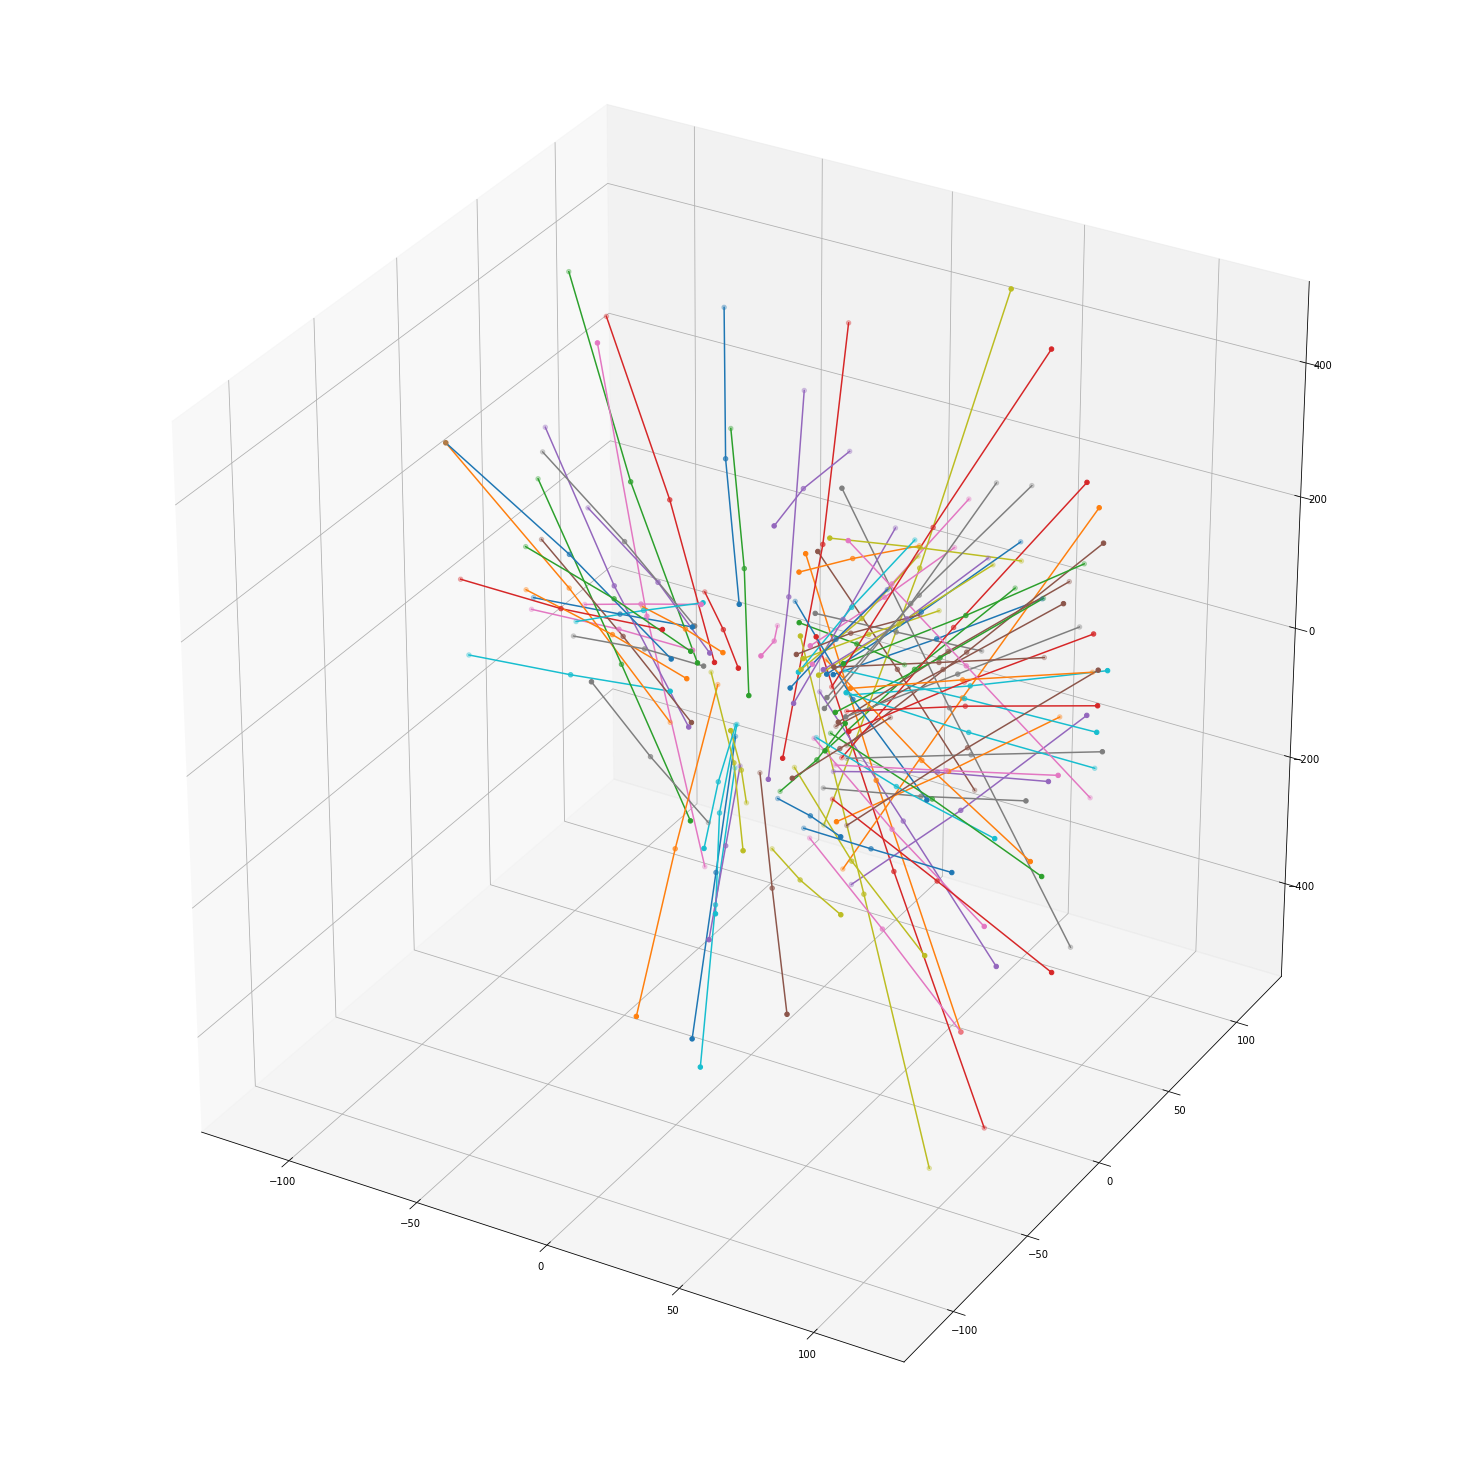

In [26]:
ax = Axes3D(plt.figure(figsize=(20,20)))
for seed in xyz[:100]:
    ax.scatter(seed[0], seed[1], seed[2])
    ax.plot(seed[0], seed[1], seed[2])
#ax.set_xlabel('r (mm)')
#ax.set_ylabel('phi (radians)')
#ax.set_zlabel('z (mm)')
plt.show()

In [28]:
len(seeds)

106816